# Dependencies

The following cell needs to be executed twice:
- the first time to install the correct version of tensorflow
- the second time to restart the session with the new installed version

In [ ]:
import tensorflow as tf
import os

if not (tf.version.VERSION == '2.9.1'):
  !pip install --upgrade tensorflow-gpu==2.9.1
  os.kill(os.getpid(), 9)
else:
  print("tensorflow version:", tf.version.VERSION)

tensorflow version: 2.9.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ttungl/adience-benchmark-gender-and-age-classification
!unzip adience-benchmark-gender-and-age-classification.zip -d adience-benchmark-gender-and-age-classification > /dev/null 2>&1

100% 1.39G/1.39G [00:13<00:00, 141MB/s]
100% 1.39G/1.39G [00:13<00:00, 112MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow import keras
%load_ext tensorboard


import os

# Data Loading

In [ ]:
fold_0=pd.read_table('/content/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/fold_0_data.txt')
fold_0

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34
...,...,...,...,...,...,...,...,...,...,...,...,...
4479,68094148@N04,11373794746_4720ac792a_o.jpg,478,"(25, 32)",m,664,0,242,211,-5,-15,73
4480,68094148@N04,11355711315_0f5b5da125_o.jpg,477,"(25, 32)",f,915,51,109,112,0,45,14
4481,10693681@N00,9162730346_b1bf71120a_o.jpg,479,"(25, 32)",m,2145,1270,249,249,10,30,25
4482,113830953@N04,11855529986_dff116e018_o.jpg,480,None,NaN,2878,1300,306,306,-100,0,164


In [ ]:
fold_1=pd.read_table('/content/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/fold_1_data.txt')
fold_1

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,114841417@N06,12068804204_085d553238_o.jpg,481,"(60, 100)",f,1141,780,975,976,0,0,118
1,114841417@N06,12068804204_085d553238_o.jpg,482,"(48, 53)",m,1821,283,969,969,-25,15,35
2,114841417@N06,12078357226_5fdd9367de_o.jpg,483,"(4, 6)",f,1788,341,306,306,-10,0,168
3,114841417@N06,12019067874_0e988248af_o.jpg,483,"(4, 6)",f,3,183,932,777,-115,0,27
4,114841417@N06,12077009614_2490487d2a_o.jpg,484,45,f,258,133,1734,1734,15,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...
3725,35953373@N04,9496952502_4e87cc8b60_o.jpg,907,"(15, 20)",m,1318,184,643,644,5,-30,78
3726,104937236@N08,11852401355_e54eba57b6_o.jpg,908,"(27, 32)",f,1310,725,573,573,-90,0,90
3727,37404707@N08,11128849885_6a56d25762_o.jpg,909,"(8, 12)",NaN,820,1099,364,364,-5,0,103
3728,37404707@N08,11182710183_e75c82dde1_o.jpg,910,"(60, 100)",NaN,1080,661,376,376,-5,0,61


In [ ]:
fold_2=pd.read_table('/content/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/fold_2_data.txt')
fold_2

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,64504106@N06,11831304783_488d6c3a6d_o.jpg,911,"(0, 2)",m,438,914,605,606,-90,0,123
1,64504106@N06,11849646776_35253e988f_o.jpg,911,"(0, 2)",m,19,712,1944,1736,-105,0,86
2,64504106@N06,11848166326_57b03f535e_o.jpg,911,"(0, 2)",m,382,680,1785,1768,-80,0,14
3,64504106@N06,11812546385_bb4d020dde_o.jpg,911,"(0, 2)",m,608,948,893,892,-105,0,8
4,64504106@N06,11831118625_81dcc72e75_o.jpg,912,"(38, 43)",m,23,150,508,508,-90,0,79
...,...,...,...,...,...,...,...,...,...,...,...,...
3889,19393853@N00,10701729133_9b74be645f_o.jpg,1317,None,NaN,2288,725,255,255,0,15,32
3890,19393853@N00,9767778096_b9ff679fb8_o.jpg,1317,None,NaN,508,337,1581,1581,-90,30,39
3891,19393853@N00,9709082628_9f1075d8ae_o.jpg,1317,None,NaN,326,93,954,867,-115,0,64
3892,19393853@N00,9767518631_71261193e8_o.jpg,1317,None,NaN,1246,353,994,995,-105,30,149


In [ ]:
fold_3=pd.read_table('/content/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/fold_3_data.txt')
fold_3

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,113445054@N07,11763777465_11d01c34ce_o.jpg,1322,"(25, 32)",m,1102,296,357,357,-15,0,59
1,113445054@N07,11763777465_11d01c34ce_o.jpg,1323,"(25, 32)",f,1713,580,325,325,-5,0,118
2,113445054@N07,11763777465_11d01c34ce_o.jpg,1324,"(15, 20)",f,1437,664,306,306,5,0,109
3,113445054@N07,11764005785_f21921aea6_o.jpg,1325,"(25, 32)",f,978,229,803,803,-20,-45,16
4,113445054@N07,11763728674_a41d99f71e_o.jpg,1326,"(25, 32)",m,1745,910,242,242,-10,0,55
...,...,...,...,...,...,...,...,...,...,...,...,...
3441,113728563@N05,11827967936_b29e8e87eb_o.jpg,1739,None,NaN,0,0,768,921,0,0,78
3442,113728563@N05,11826123976_c7d6738478_o.jpg,1742,None,NaN,450,906,932,932,0,0,127
3443,113728563@N05,11827955196_c97e4f877d_o.jpg,1743,None,NaN,72,142,560,560,20,0,13
3444,113728563@N05,11826168836_69124b9bdf_o.jpg,1741,None,NaN,0,1284,921,1160,-105,-30,74


In [ ]:
fold_4=pd.read_table('/content/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/fold_4_data.txt')
fold_4

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,115321157@N03,12111738395_a7f715aa4e_o.jpg,1744,"(4, 6)",m,663,997,637,638,-95,0,129
1,115321157@N03,12112413505_0aea8e17c6_o.jpg,1745,"(48, 53)",m,505,846,433,433,-95,0,72
2,115321157@N03,12112392255_995532c2f0_o.jpg,1744,"(4, 6)",m,517,1185,383,383,0,0,70
3,115321157@N03,12112392255_995532c2f0_o.jpg,1746,"(25, 32)",m,2247,688,376,376,0,30,67
4,115321157@N03,12112392255_995532c2f0_o.jpg,1747,"(25, 32)",m,1421,667,325,325,0,0,102
...,...,...,...,...,...,...,...,...,...,...,...,...
3811,7153718@N04,11598838386_349a0d4849_o.jpg,2282,None,NaN,596,460,1472,1473,-75,0,30
3812,7153718@N04,11598166203_c70bb34c80_o.jpg,2283,None,NaN,1179,755,331,331,5,0,108
3813,7153718@N04,11598166203_c70bb34c80_o.jpg,2282,None,NaN,1201,1179,293,293,5,0,99
3814,7153718@N04,11598145163_733cb99713_o.jpg,2282,None,NaN,1027,946,408,408,-85,0,49


In [ ]:
total_data = pd.concat([fold_0, fold_1, fold_2, fold_3, fold_4], ignore_index=True)
print(fold_0.shape)
print(total_data.shape)

(4484, 12)
(19370, 12)


In [ ]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             19370 non-null  object
 1   original_image      19370 non-null  object
 2   face_id             19370 non-null  int64 
 3   age                 19370 non-null  object
 4   gender              18591 non-null  object
 5   x                   19370 non-null  int64 
 6   y                   19370 non-null  int64 
 7   dx                  19370 non-null  int64 
 8   dy                  19370 non-null  int64 
 9   tilt_ang            19370 non-null  int64 
 10  fiducial_yaw_angle  19370 non-null  int64 
 11  fiducial_score      19370 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.8+ MB


In [ ]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


# Explorative Data Analysis

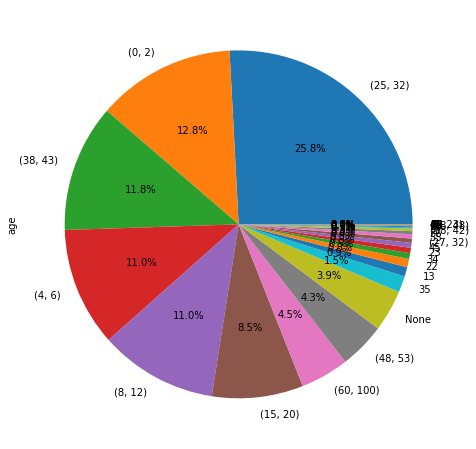

In [ ]:
plt.figure(1, figsize=(8,8))
total_data.age.value_counts().plot.pie(autopct="%1.1f%%")
plt.show()

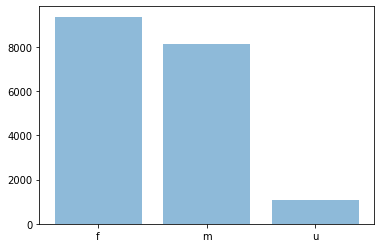

In [ ]:

#bar chart
gender = ['f','m','u']
plt.bar(gender, total_data.gender.value_counts(), align='center', alpha=0.5)
plt.show()

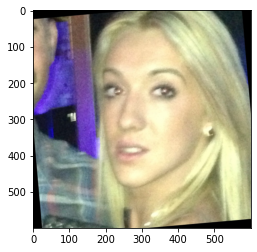

In [ ]:
path = "/content/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces/"+total_data.user_id.loc[12]+"/coarse_tilt_aligned_face."+str(total_data.face_id.loc[12])+"."+total_data.original_image.loc[12]
img = load_img(path)
plt.imshow(img)
plt.show()

In [ ]:
total_data.gender.value_counts()

f    9372
m    8120
u    1099
Name: gender, dtype: int64

In [ ]:
df = total_data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     19370 non-null  object
 1   gender  18591 non-null  object
 2   x       19370 non-null  int64 
 3   y       19370 non-null  int64 
 4   dx      19370 non-null  int64 
 5   dy      19370 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 908.1+ KB


# Data Processing

In [ ]:
# Adding Path of each Image
img_path = []
for row in total_data.iterrows():
    path = "/content/adience-benchmark-gender-and-age-classification/AdienceBenchmarkGenderAndAgeClassification/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

In [ ]:
df.head()

,age,gender,x,y,dx,dy,img_path
0,"(25, 32)",f,0,414,1086,1383,/content/adience-benchmark-gender-and-age-clas...
1,"(25, 32)",m,301,105,640,641,/content/adience-benchmark-gender-and-age-clas...
2,"(25, 32)",f,2395,876,771,771,/content/adience-benchmark-gender-and-age-clas...
3,"(25, 32)",m,752,1255,484,485,/content/adience-benchmark-gender-and-age-clas...
4,"(25, 32)",m,175,80,769,768,/content/adience-benchmark-gender-and-age-clas...


In [ ]:
# How many unique Age are there
df.age.unique()

array(['(25, 32)', '(38, 43)', '(4, 6)', '(60, 100)', '(15, 20)',
       '(48, 53)', '(8, 12)', '(0, 2)', 'None', '(38, 48)', '35', '3',
       '55', '58', '22', '13', '45', '36', '23', '(38, 42)', '(8, 23)',
       '(27, 32)', '57', '56', '2', '29', '34', '42', '46', '32'],
      dtype=object)

In [ ]:
# Mapping Ages to bring All the Ages into there respective Range
age_mapping = [('(0, 2)', '0-3'), ('2', '0-3'), ('3', '0-3'), 
               ('(4, 6)', '4-7'), 
               ('(8, 12)', '8-14'), ('13', '8-14'), 
               ('22', '15-24'), ('(8, 23)','15-24'), ('(15, 20)', '15-24'), ('23', '15-24'),
               ('(25, 32)', '25-34'), ('(27, 32)', '25-34'), ('32', '25-34'), ('34', '25-34'), ('29', '25-34'), 
               ('(38, 42)', '35-44'), ('35', '35-44'), ('36', '35-44'), ('(38, 43)', '35-44'), ('(38, 42)', '35-44'), ('42', '35-44'),('(38, 48)', '45-54'),
               ('45', '45-54'), ('46', '45-54'), ('(48, 53)', '45-54'), 
               ('55', '55+'), ('56', '55+'), ('57', '55+'), ('58', '55+'), ('(60, 100)', '55+')]
age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]
df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)

KeyError: ignored

In [ ]:
# Dropping Null Values
df = df.dropna()
unbiased_data = df[df.gender != 'u'].copy()
unbiased_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   x         17452 non-null  int64 
 3   y         17452 non-null  int64 
 4   dx        17452 non-null  int64 
 5   dy        17452 non-null  int64 
 6   img_path  17452 non-null  object
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [ ]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

age_to_label_map = {
    '0-3'  :0,
    '4-7'  :1,
    '8-14' :2,
    '15-24':3,
    '25-34':4,
    '35-44':5,
    '45-54':6,
    '55+'  :7
}

label_to_age_map = {v: k for k, v in age_to_label_map.items()}

# label_to_age_map = {value: key for key, value in age_to_label_map.items()}
# label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

unbiased_data['age'] = unbiased_data['age'].apply(lambda age: age_to_label_map[age])
unbiased_data['gender'] = unbiased_data['gender'].apply(lambda g: gender_to_label_map[g])
unbiased_data.head()

,age,gender,x,y,dx,dy,img_path
0,4,0,0,414,1086,1383,/content/adience-benchmark-gender-and-age-clas...
1,4,1,301,105,640,641,/content/adience-benchmark-gender-and-age-clas...
2,4,0,2395,876,771,771,/content/adience-benchmark-gender-and-age-clas...
3,4,1,752,1255,484,485,/content/adience-benchmark-gender-and-age-clas...
4,4,1,175,80,769,768,/content/adience-benchmark-gender-and-age-clas...


In [ ]:
# Unique Ages
unbiased_data.age.unique()

array([4, 5, 1, 7, 3, 6, 2, 0])

In [ ]:
# Splitting the Data into Train and test set
X = unbiased_data[['img_path']]
y = unbiased_data[['gender']]
yy=keras.utils.to_categorical(y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Train data shape {}'.format(X_train.shape))
print('Test data shape {}'.format(X_test.shape))

Train data shape (12216, 1)
Test data shape (5236, 1)


In [ ]:
# Remove the Index from X_train
X_train=X_train.reset_index()
X_train=X_train.drop('index',axis=1)
X_train

,img_path
0,/content/adience-benchmark-gender-and-age-clas...
1,/content/adience-benchmark-gender-and-age-clas...
2,/content/adience-benchmark-gender-and-age-clas...
3,/content/adience-benchmark-gender-and-age-clas...
4,/content/adience-benchmark-gender-and-age-clas...
...,...
12211,/content/adience-benchmark-gender-and-age-clas...
12212,/content/adience-benchmark-gender-and-age-clas...
12213,/content/adience-benchmark-gender-and-age-clas...
12214,/content/adience-benchmark-gender-and-age-clas...


In [ ]:
# Remove the index from y_train
y_train=y_train.reset_index()
y_train=y_train.drop('index',axis=1)
y_train

,gender
0,1
1,0
2,0
3,1
4,0
...,...
12211,1
12212,0
12213,0
12214,0


In [ ]:
# Creating The Data Frame for train images and 
train=pd.DataFrame({'Image_path':X_train.iloc[:,0],'Gender':y_train.iloc[:,0]},index=X_train.index)
train

,Image_path,Gender
0,/content/adience-benchmark-gender-and-age-clas...,1
1,/content/adience-benchmark-gender-and-age-clas...,0
2,/content/adience-benchmark-gender-and-age-clas...,0
3,/content/adience-benchmark-gender-and-age-clas...,1
4,/content/adience-benchmark-gender-and-age-clas...,0
...,...,...
12211,/content/adience-benchmark-gender-and-age-clas...,1
12212,/content/adience-benchmark-gender-and-age-clas...,0
12213,/content/adience-benchmark-gender-and-age-clas...,0
12214,/content/adience-benchmark-gender-and-age-clas...,0


In [ ]:
# Doing the Same for test Data 
X_test=X_test.reset_index()
X_test=X_test.drop('index',axis=1)
y_test=y_test.reset_index()
y_test=y_test.drop('index',axis=1)
X_test,y_test

(                                               img_path
 0     /content/adience-benchmark-gender-and-age-clas...
 1     /content/adience-benchmark-gender-and-age-clas...
 2     /content/adience-benchmark-gender-and-age-clas...
 3     /content/adience-benchmark-gender-and-age-clas...
 4     /content/adience-benchmark-gender-and-age-clas...
 ...                                                 ...
 5231  /content/adience-benchmark-gender-and-age-clas...
 5232  /content/adience-benchmark-gender-and-age-clas...
 5233  /content/adience-benchmark-gender-and-age-clas...
 5234  /content/adience-benchmark-gender-and-age-clas...
 5235  /content/adience-benchmark-gender-and-age-clas...
 
 [5236 rows x 1 columns],       gender
 0          1
 1          1
 2          1
 3          1
 4          1
 ...      ...
 5231       0
 5232       0
 5233       0
 5234       1
 5235       1
 
 [5236 rows x 1 columns])

In [ ]:
# Create the Data Frame for test Data or Validation Data 
test=pd.DataFrame({'Image_path':X_test.iloc[:,0],'Label':y_test.iloc[:,0]},index=X_test.index)
test

,Image_path,Label
0,/content/adience-benchmark-gender-and-age-clas...,1
1,/content/adience-benchmark-gender-and-age-clas...,1
2,/content/adience-benchmark-gender-and-age-clas...,1
3,/content/adience-benchmark-gender-and-age-clas...,1
4,/content/adience-benchmark-gender-and-age-clas...,1
...,...,...
5231,/content/adience-benchmark-gender-and-age-clas...,0
5232,/content/adience-benchmark-gender-and-age-clas...,0
5233,/content/adience-benchmark-gender-and-age-clas...,0
5234,/content/adience-benchmark-gender-and-age-clas...,1


# Data Split

In [ ]:
from keras.utils import to_categorical

In [ ]:
NUM_CLASSES = 8

In [ ]:
x = unbiased_data[['img_path']]
y = unbiased_data[['age']]
#y=keras.utils.to_categorical(y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
print('Train data shape {}'.format(X_train.shape))
print('test data shape {}'.format(X_test.shape))

Train data shape (12216, 1)
test data shape (5236, 1)


In [ ]:
one_hot = pd.DataFrame(to_categorical(y_train["age"], NUM_CLASSES))
column_labels_name = [f"age_{x}" for x in range(NUM_CLASSES)]
  
y_train=y_train.reset_index()
y_train=y_train.drop('index',axis=1)

one_hot.columns = column_labels_name # change labels name
y_train = y_train.drop("age", axis = 1) # drop old not hot-encoded columns 
y_train = pd.concat([y_train, one_hot], axis=1) # add new hot-encoded columns 


y_train

,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
12211,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
12212,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12213,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
12214,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
y_test=y_test.reset_index()
y_test=y_test.drop('index',axis=1)

one_hot = pd.DataFrame(to_categorical(y_test["age"], NUM_CLASSES))
column_labels_name = [f"age_{x}" for x in range(NUM_CLASSES)]

one_hot.columns = column_labels_name # change labels name
y_test = y_test.drop("age", axis = 1) # drop old not hot-encoded columns 
y_test = pd.concat([y_test, one_hot], axis=1) # add new hot-encoded columns 


y_test

,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
5231,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5232,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5233,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5234,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
test.columns=['Image_path','Gender_label']
train.columns=['Image_path','Gender_label']

In [ ]:
train.head()

,Image_path,Gender_label
0,/content/adience-benchmark-gender-and-age-clas...,1
1,/content/adience-benchmark-gender-and-age-clas...,0
2,/content/adience-benchmark-gender-and-age-clas...,0
3,/content/adience-benchmark-gender-and-age-clas...,1
4,/content/adience-benchmark-gender-and-age-clas...,0


In [ ]:
train[column_labels_name]=y_train
test[column_labels_name]=y_test

In [ ]:
train.head()

,Image_path,Gender_label,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7
0,/content/adience-benchmark-gender-and-age-clas...,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,/content/adience-benchmark-gender-and-age-clas...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,/content/adience-benchmark-gender-and-age-clas...,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/content/adience-benchmark-gender-and-age-clas...,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,/content/adience-benchmark-gender-and-age-clas...,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
train.to_csv('train.csv')
test.to_csv('test.csv')

# Data Loading

In [ ]:
TOTAL_LABEL=["Image_path"]+column_labels_name
TOTAL_LABEL

['Image_path',
 'age_0',
 'age_1',
 'age_2',
 'age_3',
 'age_4',
 'age_5',
 'age_6',
 'age_7']

In [ ]:
train_age_df = train[TOTAL_LABEL]
train_gender_df = train[["Image_path", "Gender_label"]]

test_age_df = test[TOTAL_LABEL]
test_gender_df = test[["Image_path", "Gender_label"]]

train_age_df.head()

,Image_path,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7
0,/content/adience-benchmark-gender-and-age-clas...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,/content/adience-benchmark-gender-and-age-clas...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,/content/adience-benchmark-gender-and-age-clas...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/content/adience-benchmark-gender-and-age-clas...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,/content/adience-benchmark-gender-and-age-clas...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# converting back to string because CNNs need a categorical input
train_age_df[column_labels_name] = train_age_df[column_labels_name].astype(int)
test_age_df[column_labels_name] = test_age_df[column_labels_name].astype(int)

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                                                            validation_split=0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)
BATCH_SIZE=64
IMG_SIZE = 224
RANDOM_SEED = 42

train_generator = train_gen.flow_from_dataframe(
    dataframe=train_age_df,
    directory="",
    x_col="Image_path",
    y_col=column_labels_name,
    subset="training",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, # 32 default
    class_mode='raw',
    shuffle=True, 
    seed=RANDOM_SEED,
    )

val_generator = train_gen.flow_from_dataframe(
    dataframe=train_age_df,
    directory="",
    x_col="Image_path",
    y_col=column_labels_name,
    subset="validation",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, # 32 default
    class_mode='raw',
    shuffle=True, 
    seed=RANDOM_SEED,
    )

test_generator = test_gen.flow_from_dataframe(
    dataframe=test_age_df,
    directory="",
    x_col="Image_path",
    y_col=column_labels_name,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True, 
    seed=RANDOM_SEED,
    )

<ipython-input-46-6a635505ceb5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_age_df[column_labels_name] = train_age_df[column_labels_name].astype(int)
<ipython-input-46-6a635505ceb5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_age_df[column_labels_name] = test_age_df[column_labels_name].astype(int)


Found 9773 validated image filenames.
Found 2443 validated image filenames.
Found 5236 validated image filenames.


# Fine-Tuning

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout

from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0

base_eff_model = EfficientNetB0(weights="imagenet", include_top=True, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_eff_model.summary()

In [ ]:
n_classes=8
input_shape = (224,224,3)

## Layers Freezing

In [ ]:
MODELS_PATH="/content/drive/MyDrive/Lab-Proj/models/"

In [ ]:
trainable_layer = False
for layer in base_eff_model.layers:
    if layer.name == "block5a_expand_conv":
        trainable_layer=True
    layer.trainable=trainable_layer

eff_model = Model(inputs=base_eff_model.input, outputs=base_eff_model.get_layer('top_dropout').output)

last_layer = base_eff_model.get_layer('top_dropout').output

flatten_layer = Flatten()(last_layer)
dropout_layer = Dropout(rate=0.2)(flatten_layer)

classification_layer = Dense(8, activation='softmax', kernel_regularizer='l2')(dropout_layer)

eff_model = Model(inputs=eff_model.input, outputs=classification_layer)

eff_model.summary()

## Tuning

In [ ]:
model_path = "/content/drive/MyDrive/Lab-Proj/"+"models/EfficientNetB0_age_tuning5a_dropout.h5"

if os.path.exists(model_path):
    print("Loading trained model . . .")
    eff_model = keras.models.load_model(model_path)
else: 
    eff_model.compile(loss='categorical_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    history = eff_model.fit(train_generator, 
                            epochs=30,
                            callbacks=[early_stop], 
                            verbose=1, 
                            validation_data=val_generator)

    eff_model.save(model_path)

Loading trained model . . .
